## **IDX Exchange Home Price Prediction**
## **Task 1: Data Exploration & Preprocessing**

• Trimmed ClosePrice to [$50k–$10M]; created PricePerSqft and cleaned extreme values.

• Price is right-skewed; price rises with living area with larger spread at higher sizes.

• Saved ../data/cleaned_enhanced.csv for modeling.

#### 1. Imports & Setup

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

#### 2. Load and Merge Raw CRMLS Files

In [2]:
data_path = Path("../data")

csv_files = glob.glob(str(data_path / "CRMLSSold*.csv"))
print("Found CSVs:", [Path(f).name for f in csv_files])

if not csv_files:
    raise FileNotFoundError(f"No CRMLSSold*.csv files found in {data_path.resolve()}")

Found CSVs: ['CRMLSSold202508.csv', 'CRMLSSold202503.csv', 'CRMLSSold202502.csv', 'CRMLSSold202505.csv', 'CRMLSSold202504.csv', 'CRMLSSold202506.csv', 'CRMLSSold202507.csv']


In [3]:
# Merge all monthly CRMLS datasets
df_list = [pd.read_csv(f) for f in csv_files]
df_all_raw = pd.concat(df_list, ignore_index=True)
print("Merged shape:", df_all_raw.shape)

# Save merged dataset
output_path = data_path / "all_raw.csv"
df_all_raw.to_csv(output_path, index=False)
print(f"Saved merged dataset → {output_path}")

/var/folders/4m/_gbynxg10v9__2c2z52hgcnm0000gn/T/ipykernel_16014/1724506622.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f) for f in csv_files]


Merged shape: (156064, 78)
Saved merged dataset → ../data/all_raw.csv


#### 3. Filter Relevant Property Types

In [4]:
df_all = df_all_raw.copy()
if {"PropertyType", "PropertySubType"}.issubset(df_all.columns):
    df_all["PropertySubType"] = df_all["PropertySubType"].astype(str)
    mask_pt = df_all["PropertyType"].str.contains("residential", case=False, na=False)
    mask_ps = df_all["PropertySubType"].str.contains("single", case=False, na=False)
    df_all = df_all[mask_pt & mask_ps]

print("After filtering Residential/SFR:", df_all.shape)

After filtering Residential/SFR: (95606, 78)


#### 4. Clean Target and Handle Outliers

In [5]:
# Resolve target (Close Price)
target_candidates = ["ClosePrice", "Close Price", "Close_Price", "CLOSEPRICE"]
target = next((c for c in target_candidates if c in df_all.columns), None)
assert target is not None, f"Target not found. Tried: {target_candidates}"

In [6]:
# ListPrice resolution
listprice_candidates = ["ListPrice", "List Price", "List_Price", "LISTPRICE"]
lp = next((c for c in listprice_candidates if c in df_all.columns), None)

orig_lp_candidates = ["OriginalListPrice", "Original List Price", "Original_List_Price", "ORIGINALLISTPRICE"]
orig_lp = next((c for c in orig_lp_candidates if c in df_all.columns), None)

if lp:
    df_all[lp] = pd.to_numeric(df_all[lp], errors="coerce")
if orig_lp:
    df_all[orig_lp] = pd.to_numeric(df_all[orig_lp], errors="coerce")

In [7]:
# I need to keep reasonable target range & non-null
df_all = df_all[df_all[target].between(50_000, 10_000_000)]
df_all = df_all.dropna(subset=[target])
print("After removing outliers & NaNs:", df_all.shape)

After removing outliers & NaNs: (78396, 78)


In [8]:
LOW, HIGH = 50_000, 10_000_000
n0 = len(df_all)
df_all = df_all[df_all[target].between(LOW, HIGH)]
print(f"Trimmed extreme {target} values: {n0 - len(df_all)} rows removed "
      f"(kept in [{LOW:,} .. {HIGH:,}])")

Trimmed extreme ClosePrice values: 0 rows removed (kept in [50,000 .. 10,000,000])


In [9]:
# Bound ListPrice similarly but don't drop rows—just null implausible
if lp:
    n_before = df_all[lp].notna().sum()
    df_all.loc[~df_all[lp].between(LOW, HIGH), lp] = np.nan
    print(f"ListPrice: set {n_before - df_all[lp].notna().sum()} extreme values to NaN (kept in [{LOW:,} .. {HIGH:,}])")

ListPrice: set 68 extreme values to NaN (kept in [50,000 .. 10,000,000])


#### 5. Feature Engineering

In [10]:
# Resolve living area column once
living_candidates = ["LivingArea", "Living Area", "SQFT", "SquareFootage", "Square_Footage"]
living = next((c for c in living_candidates if c in df_all.columns), None)

In [11]:
# Price per sqft using resolved living area
if living:
    df_all["PricePerSqft"] = df_all[target] / df_all[living].clip(lower=1)
    
    # Clip extreme PPSF tail
    df_all["PricePerSqft"] = df_all["PricePerSqft"].clip(upper=df_all["PricePerSqft"].quantile(0.99))
    print(f"Added PricePerSqft (living column: {living})")

Added PricePerSqft (living column: LivingArea)


In [12]:
# ListPrice-per-sqft
if lp and living:
    df_all["ListPricePerSqft"] = df_all[lp] / df_all[living]
    df_all["ListPricePerSqft"].replace([np.inf, -np.inf], np.nan, inplace=True)
    p99_lp_psf = df_all["ListPricePerSqft"].quantile(0.99)
    df_all["ListPricePerSqft"] = df_all["ListPricePerSqft"].clip(upper=p99_lp_psf)
    print("ListPricePerSqft 99th percentile:", round(p99_lp_psf, 2))

ListPricePerSqft 99th percentile: 1815.33


#### 6. Save Cleaned Dataset

In [13]:
# ListPrice: compare List vs Close --> Deal-level LP vs SP metrics
if lp:
    df_all["LP_to_SP_Ratio"] = df_all[target] / df_all[lp]
    df_all["PriceDelta"] = df_all[target] - df_all[lp]
    df_all["PricePctDiff"] = (df_all["PriceDelta"] / df_all[lp]).replace([np.inf, -np.inf], np.nan)

In [14]:
# Freeze cleaned dataset
df_clean = df_all.reset_index(drop=True)
output_file = data_path / "cleaned_enhanced.csv"
df_clean.to_csv(output_file, index=False)
print(f"Saved cleaned dataset → {output_file} | Shape: {df_clean.shape}")

Saved cleaned dataset → ../data/cleaned_enhanced.csv | Shape: (78396, 83)


#### Missingness snapshot

In [15]:
# Missingness (on the saved dataset)
missing_pct = (
    df_clean.isna().mean().sort_values(ascending=False).mul(100).round(1)
)
miss_tbl = missing_pct[missing_pct > 0].head(15).to_frame("Missing %")
display(miss_tbl)

,Missing %
MiddleOrJuniorSchoolDistrict,100.0
FireplacesTotal,100.0
TaxYear,100.0
CoveredSpaces,100.0
BusinessType,100.0
AboveGradeFinishedArea,100.0
ElementarySchoolDistrict,100.0
TaxAnnualAmount,100.0
WaterfrontYN,100.0
BelowGradeFinishedArea,99.3


#### 7. Visualization

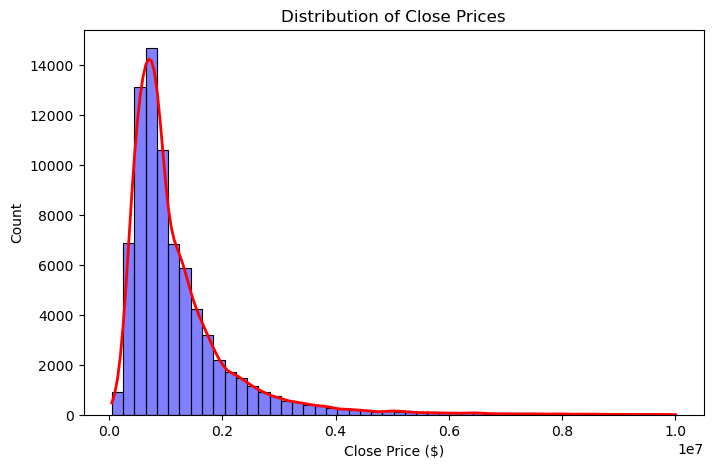

In [16]:
# Distribution of Close Prices
plt.figure(figsize=(8,5))
ax = sns.histplot(
    df_clean["ClosePrice"],
    bins=50,
    kde=True,
    color="blue"   
)

for line in ax.lines:
    line.set_color("red")
    line.set_linewidth(2)

plt.title("Distribution of Close Prices")
plt.xlabel("Close Price ($)")
plt.ylabel("Count")
plt.show()

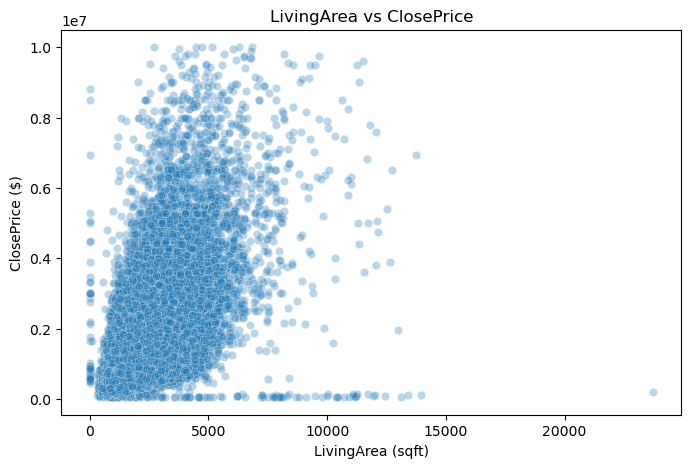

In [17]:
# PricePerSqft (robust, single place) --> Living Area vs Close Price
x_col = living if living else "LivingArea"
if x_col in df_clean.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=x_col, y=target, data=df_clean, alpha=0.3)
    plt.title(f"{x_col} vs {target}")
    plt.xlabel(f"{x_col} (sqft)" if ("Area" in x_col or "SQFT" in x_col) else x_col)
    plt.ylabel(f"{target} ($)")
    plt.show()

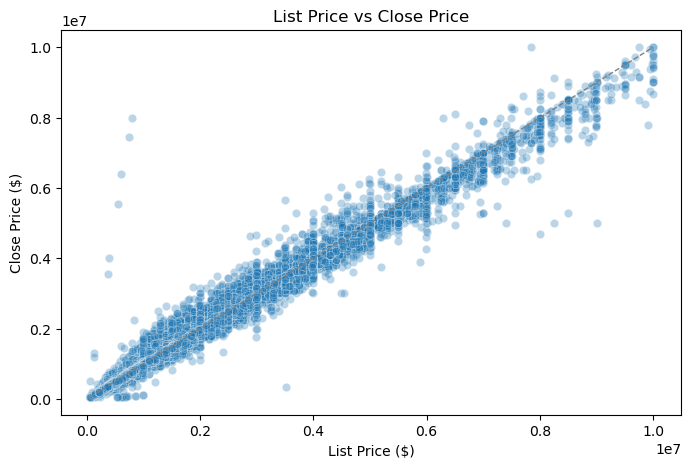

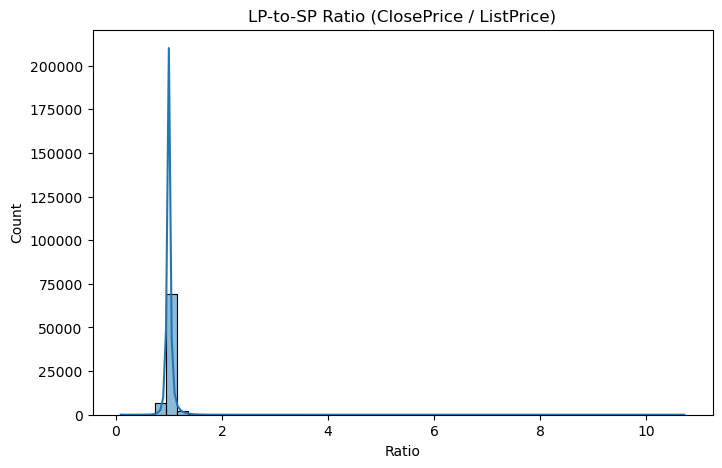

In [18]:
# ListPrice visual diagnostics
if lp:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=df_clean[lp], y=df_clean[target], alpha=0.3)
    plt.title("List Price vs Close Price")
    plt.xlabel("List Price ($)")
    plt.ylabel("Close Price ($)")
    plt.plot(
        [df_clean[lp].min(), df_clean[lp].max()],
        [df_clean[lp].min(), df_clean[lp].max()],
        linestyle="--", linewidth=1, color="gray"
    )
    plt.show()

    if "LP_to_SP_Ratio" in df_clean.columns:
        plt.figure(figsize=(8,5))
        sns.histplot(df_clean["LP_to_SP_Ratio"].dropna(), bins=50, kde=True)
        for line in ax.lines:
            line.set_color("red")
            line.set_linewidth(2)
        plt.title("LP-to-SP Ratio (ClosePrice / ListPrice)")
        plt.xlabel("Ratio")
        plt.ylabel("Count")
        plt.show()


From the plots above:
- Most property close prices fall below $2M, with a right-skewed distribution.
- There is a clear positive relationship between living area and property price.
- This validates that **LivingArea** and related features are strong predictors for our model training in Task 2.


#### 8. Quick Summary

In [19]:
display(df_clean.head())

,BuyerAgentAOR,ListAgentAOR,Flooring,ViewYN,WaterfrontYN,BasementYN,PoolPrivateYN,OriginalListPrice,ListingKey,ListAgentEmail,...,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict,PricePerSqft,ListPricePerSqft,LP_to_SP_Ratio,PriceDelta,PricePctDiff
0,SanDiego,SanDiego,Bamboo,True,NaN,NaN,False,2800000.0,1130907846,vickicoronado@gmail.com,...,NaN,92118,325.0,NaN,NaN,943.396226,943.396226,1.0,0.0,0.0
1,PacificSouthwest,PacificSouthwest,NaN,False,NaN,NaN,True,1675000.0,1130879923,jennifer@homesbystclair.com,...,Chula Vista Elementary,91910,0.0,34412.4,NaN,442.887361,442.887361,1.0,0.0,0.0
2,Mlslistings,Mlslistings,NaN,False,NaN,NaN,NaN,NaN,1130834243,susan@susanwoods.com,...,Other,95032,NaN,8023.0,NaN,1461.949266,1461.949266,1.0,0.0,0.0
3,Mlslistings,Mlslistings,NaN,False,NaN,NaN,NaN,2500000.0,1130746481,bbarnes@intero.com,...,Other,94087,NaN,6000.0,NaN,1636.125654,1636.125654,1.0,0.0,0.0
4,SierraNorthValley,SierraNorthValley,"Tile,Vinyl",True,NaN,NaN,False,660000.0,1130727503,doug@realspeicher.com,...,Paradise Unified,95969,0.0,26572.0,NaN,309.423347,309.423347,1.0,0.0,0.0


In [20]:
display(df_clean.describe(include='all').transpose())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
BuyerAgentAOR,78386,53,OrangeCounty,5807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ListAgentAOR,78386,53,OrangeCounty,5807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flooring,50658,234,"Carpet,Tile",5571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ViewYN,71129,2,True,43523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WaterfrontYN,36,1,True,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
PricePerSqft,78139.0,NaN,NaN,NaN,599.584748,331.691923,4.196871,348.984882,534.861509,750.373329,1893.451464
ListPricePerSqft,78027.0,NaN,NaN,NaN,593.618859,318.60131,4.196871,351.793058,533.831909,741.943769,1815.331596
LP_to_SP_Ratio,78328.0,NaN,NaN,NaN,1.005163,0.121236,0.08908,0.97619,1.0,1.020036,10.72052
PriceDelta,78328.0,NaN,NaN,NaN,1156.310016,130665.970673,-4000000.0,-21520.75,0.0,15000.0,7200000.0
